<a href="https://colab.research.google.com/github/BCI-and-Neuroergonomics-Lab/3D-MB-CNN/blob/dev/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive


In [ ]:
# Loading your drive so CoLab has access to it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Softmax
from tensorflow.keras.layers import Conv3D, SpatialDropout3D, AveragePooling3D
from tensorflow.keras.layers import Conv2D, SpatialDropout2D, AveragePooling2D
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Flatten, Add
from tensorflow.keras.constraints import max_norm

import numpy as np
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython import display
from datetime import datetime
from uuid import uuid4

import pickle

try:
  import mne
except ModuleNotFoundError:
  !pip install mne
  import mne

# Check For GPU Presence

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Constants


In [ ]:
VERBOSE = 0

MODE = "Motor"
DIMENSION = '2D'
BRANCHED = 'MRF'
#PREFILTERED = False
TRAIN_PROCESSING_STAGE = "FULL"
TEST_PROCESSING_STAGE = "SHUFFLED"
VAL_PROCESSING_STAGE = "SHUFFLED"
NUM_CLASSES = 4

KFOLD = True
KFOLD_NUM = 5

# Options are 'sparse_categorical_crossentropy', 'mean_absolute_error', 'mean_squared_error', or 'categorical_crossentropy'
# Can be anything Keras accepts, above are just examples
LOSS_FUNCTION = 'categorical_crossentropy'

# Options are 'Adam' or 'SGD'
OPTIMIZER_OPTION = "Adam"

if (BRANCHED == 'MB'):
  BRANCHES = ("SRF", "MRF", "LRF")
elif (BRANCHED == 'SRF'):
  BRANCHES = ("SRF", )
elif (BRANCHED == 'MRF'):
  BRANCHES = ("MRF", )
elif (BRANCHED == 'LRF'):
  BRANCHES = ("LRF", )
DEFAULT_CHANNELS = 22
DEFAULT_SAMPLES = 313

EPOCHS = 300

# ---- Directory Stuff ---------------------------------------------------------

PICKLE_OUT_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Output/Pickle.out"

EMOTION_PROCESSED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_processed"
EMOTION_CROPPED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_cropped"
EMOTION_AVERAGED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_averaged"
EMOTION_SHUFFLED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_shuffled"
EMOTION_FULL_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/SEED/SEED_IV_full"

EMOTION_DIR_DICT = {"PROCESSED": EMOTION_PROCESSED_DIR, "CROPPED": EMOTION_CROPPED_DIR, "AVERAGED": EMOTION_AVERAGED_DIR, "SHUFFLED": EMOTION_SHUFFLED_DIR, "FULL": EMOTION_FULL_DIR}

MOTOR_PROCESSED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/BCICIV_2a/BCICIV_2a_processed"
MOTOR_CROPPED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/BCICIV_2a/BCICIV_2a_cropped"
MOTOR_AVERAGED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/BCICIV_2a/BCICIV_2a_averaged"
MOTOR_SHUFFLED_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/BCICIV_2a/BCICIV_2a_shuffled"
MOTOR_FULL_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/BCICIV_2a/BCICIV_2a_full"

MOTOR_DIR_DICT = {"PROCESSED": MOTOR_PROCESSED_DIR, "CROPPED": MOTOR_CROPPED_DIR, "AVERAGED": MOTOR_AVERAGED_DIR, "SHUFFLED": MOTOR_SHUFFLED_DIR, "FULL": MOTOR_FULL_DIR}

GDF_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Datasets/GDF/"
GDF_FILES = ["MI_calib1_record.gdf", "MI_calib2_record.gdf", "MI_calib3_record.gdf", "MI_calib4_record.gdf"]

SUFFIX_DICT = {"PROCESSED": "_processed.npy", "CROPPED": "_cropped.npy", "AVERAGED": "_averaged.npy", "SHUFFLED": "_shuffled.npy", "FULL": "_full.npy"}

TRAIN_DIR_APPEND = "train/"
TEST_DIR_APPEND = "test/"
VAL_DIR_APPEND = "val/"

TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
VAL_SPLIT = 0.2

MOTOR_STEP_SIZE = 20
#EMOTION_STEP_SIZE = 10
EMOTION_STEP_SIZE = 10

if (MODE == 'Motor'):
  STEP_SIZE = MOTOR_STEP_SIZE
elif (MODE == 'Emotion'):
  STEP_SIZE = EMOTION_STEP_SIZE
else:
  STEP_SIZE = 0
  print("Step size intended for use on either Motor or Emotion Datasets, not GDF files.")

WINDOW_SIZE = 313

XDIM = 7
YDIM = 6
NUM_CHANNELS = 22

if (MODE == 'Emotion'):
  try:
    TRAIN_DIR = EMOTION_DIR_DICT[TRAIN_PROCESSING_STAGE]
    TRAIN_SUFFIX = SUFFIX_DICT[TRAIN_PROCESSING_STAGE]

    TEST_DIR = EMOTION_DIR_DICT[TEST_PROCESSING_STAGE]
    TEST_SUFFIX = SUFFIX_DICT[TEST_PROCESSING_STAGE]

    VAL_DIR = EMOTION_DIR_DICT[VAL_PROCESSING_STAGE]
    VAL_SUFFIX = SUFFIX_DICT[VAL_PROCESSING_STAGE]

  except KeyError:
    raise Exception("Invalid Data Processing Stage, please specify 'PROCESSED', 'CROPPED', 'AVERAGED', or 'SHUFFLED'.")

  DISPLAY_LABELS = ['Neutral', 'Sad', 'Fear', 'Happy']

elif (MODE == 'Motor'):
  try:
    TRAIN_DIR = MOTOR_DIR_DICT[TRAIN_PROCESSING_STAGE]
    TRAIN_SUFFIX = SUFFIX_DICT[TRAIN_PROCESSING_STAGE]

    TEST_DIR = MOTOR_DIR_DICT[TEST_PROCESSING_STAGE]
    TEST_SUFFIX = SUFFIX_DICT[TEST_PROCESSING_STAGE]

    VAL_DIR = MOTOR_DIR_DICT[VAL_PROCESSING_STAGE]
    VAL_SUFFIX = SUFFIX_DICT[VAL_PROCESSING_STAGE]
    
  except KeyError:
    raise Exception("Invalid Data Processing Stage, please specify 'PROCESSED', 'CROPPED', 'AVERAGED', or 'SHUFFLED'.")

  DISPLAY_LABELS = ['Left', 'Right', 'Foot', 'Tongue']

elif (MODE == 'GDF'):
  TRAIN_TEST_SPLIT_SIZE = 0.2
  DISPLAY_LABELS = ('Left', 'Right')#, 'Foot', 'Tongue')
  CUES_DICT = {'Left':'769', 'Right':'770', 'Tongue':'780', 'Foot':'774'}
  CUES = ('Left', 'Right')#, 'Foot', 'Tongue')
  BAD_CHANNELS = ('EOG-left', 'EOG-central', 'EOG-right')

  # Time window (starts TMIN seconds after stim and ends TMAX seconds after stim)
  TMIN = 0.5
  TMAX = 2.5

  # Scales data due to weird OpenViBE behavior
  DATA_SCALING_FACTOR = 1000

  CROP = True
else:
  raise Exception("Invalid Data Mode, please specify 'Emotion' or 'Motor'.")

if (OPTIMIZER_OPTION == 'Adam'):
  OPTIMIZER = tf.keras.optimizers.Adam
elif (OPTIMIZER_OPTION == 'SGD'):
  OPTIMIZER = tf.keras.optimizers.SGD
else:
  raise Exception("Invalid Optimizer Option, please specify 'Adam' or 'SGD'.")
  
DIM_3D_SUFFIX = "_3d/"
DIM_2D_SUFFIX = "_2d/"

if (MODE != 'GDF'):
  if (DIMENSION == '3D'):
    if (TRAIN_PROCESSING_STAGE != "FULL"):
      TRAIN_DIR = TRAIN_DIR + DIM_3D_SUFFIX + TRAIN_DIR_APPEND
    else:
      TRAIN_DIR = TRAIN_DIR + DIM_3D_SUFFIX
    TEST_DIR = TEST_DIR + DIM_3D_SUFFIX + TEST_DIR_APPEND
    VAL_DIR = VAL_DIR + DIM_3D_SUFFIX + VAL_DIR_APPEND
  elif (DIMENSION == '2D'):
    if (TRAIN_PROCESSING_STAGE != "FULL"):
      TRAIN_DIR = TRAIN_DIR + DIM_2D_SUFFIX + TRAIN_DIR_APPEND
    else:
      TRAIN_DIR = TRAIN_DIR + DIM_2D_SUFFIX
    TEST_DIR = TEST_DIR + DIM_2D_SUFFIX + TEST_DIR_APPEND
    VAL_DIR = VAL_DIR + DIM_2D_SUFFIX + VAL_DIR_APPEND
  else:
    raise Exception("Invalid Dimension, please specify '3D' or '2D'.")

# ------------------------------------------------------------------------------

# Metrics

ACCURACY_METRIC = True
PRECISION_METRIC = True
RECALL_METRIC = True

# Epoch End Callback
EPOCH_END = False

# Profiling Callback
PROFILING = False
PROFILING_OUT_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Output/TensorBoard/"

# Early Stopping Callback
EARLY_STOPPING = True
EARLY_STOPPING_PATIENCE = 50

# Model Checkpointing Callback
MODEL_CHECKPOINTING = True
CHECKPOINT_OUT_DIR = "/content/drive/MyDrive/BCI-Lab-Drive/Output/Checkpoints/" + str(uuid4())
print("Saving Checkpointed Models to:\n" + CHECKPOINT_OUT_DIR)

# Live Plot
# Supported values include 'Loss', 'Accuracy', and 'F1-Score'
# These values will override the above metrics, as they must be included for plot
LIVE_PLOTTING = True
PLOT_METRIC = 'Accuracy'
BAD_PLOT_METRIC = "Unimplemented Plot Metric, please check the value of constant 'PLOT_METRIC'."

# Dataset Information
EMOTION_NUM_SUBJECTS = 15
MOTOR_NUM_SUBJECTS = 9

# How data will be managed, options are 'single-subject' and 'superset'
DATA_METHOD = 'single-subject'
SINGLE_SUBJECT_NUM = 9

# Results in a shuffle following data creation and when the Kfolds are generated
SHUFFLE = True


if (MODE == 'Motor'):
  if (NUM_CLASSES == 4):
    # Parameters for EEGNet3D
    D_3D = 4
    F1_3D = 16
    F2_3D = 4
    CONV_SIZE_3D = 9
    DROPOUT_RATE_3D = 0.5
    DROPOUT_TYPE_3D = 'Dropout'
    SMALL_KERNEL_LENGTH_3D = 29
    MEDIUM_KERNEL_LENGTH_3D = 96
    LARGE_KERNEL_LENGTH_3D = 139
    NORM_RATE_3D = 0.25
    POOLING_1_3D = 7
    POOLING_2_3D = 5
    SPATIAL_SIZE_3D = 4
    BATCH_SIZE = 75
    INIT_LR = 0.0001

    # Parameters for EEGNet2D
    D_2D = 4
    F1_2D = 2
    F2_2D = 32
    CONV_SIZE_2D = 4
    DROPOUT_RATE_2D = 0.5
    DROPOUT_TYPE_2D = 'Dropout'
    SMALL_KERNEL_LENGTH_2D = 64 # was 2
    MEDIUM_KERNEL_LENGTH_2D = 128
    LARGE_KERNEL_LENGTH_2D = 261 # Was 189
    NORM_RATE_2D = 0.25
    POOLING_1_2D = 2
    POOLING_2_2D = 5
    BATCH_SIZE = 32
    INIT_LR = 0.0001
  elif (NUM_CLASSES == 3):
    # Parameters for EEGNet3D
    D_3D = 4
    F1_3D = 9
    F2_3D = 4
    CONV_SIZE_3D = 16
    DROPOUT_RATE_3D = 0.2
    DROPOUT_TYPE_3D = 'SpatialDropout3D'
    SMALL_KERNEL_LENGTH_3D = 116
    MEDIUM_KERNEL_LENGTH_3D = 116
    LARGE_KERNEL_LENGTH_3D = 192
    NORM_RATE_3D = 0.45
    POOLING_1_3D = 4
    POOLING_2_3D = 5
    SPATIAL_SIZE_3D = 6
    BATCH_SIZE = 131
    INIT_LR = 0.001

    # Parameters for EEGNet2D
    D_2D = 3
    F1_2D = 16
    F2_2D = 12
    CONV_SIZE_2D = 32
    DROPOUT_RATE_2D = 0.25
    DROPOUT_TYPE_2D = 'Dropout'
    SMALL_KERNEL_LENGTH_2D = 34
    MEDIUM_KERNEL_LENGTH_2D = 64
    LARGE_KERNEL_LENGTH_2D = 256
    NORM_RATE_2D = 0.785
    POOLING_1_2D = 8
    POOLING_2_2D = 6
    BATCH_SIZE = 131
    INIT_LR = 0.001
  elif (NUM_CLASSES == 2):
    # Parameters for EEGNet3D
    D_3D = 4
    F1_3D = 9
    F2_3D = 4
    CONV_SIZE_3D = 16
    DROPOUT_RATE_3D = 0.2
    DROPOUT_TYPE_3D = 'SpatialDropout3D'
    SMALL_KERNEL_LENGTH_3D = 116
    MEDIUM_KERNEL_LENGTH_3D = 116
    LARGE_KERNEL_LENGTH_3D = 192
    NORM_RATE_3D = 0.45
    POOLING_1_3D = 4
    POOLING_2_3D = 5
    SPATIAL_SIZE_3D = 6
    BATCH_SIZE = 131
    INIT_LR = 0.001

    # Parameters for EEGNet2D
    D_2D = 2
    F1_2D = 9
    F2_2D = 12
    CONV_SIZE_2D = 22
    DROPOUT_RATE_2D = 0.103
    DROPOUT_TYPE_2D = 'SpatialDropout2D'
    SMALL_KERNEL_LENGTH_2D = 45
    MEDIUM_KERNEL_LENGTH_2D = 87
    LARGE_KERNEL_LENGTH_2D = 211
    NORM_RATE_2D = 0.999
    POOLING_1_2D = 4
    POOLING_2_2D = 3
    BATCH_SIZE = 131
    INIT_LR = 0.001
elif (MODE == 'Emotion'):
  # Parameters for EEGNet3D
  D_3D = 4
  F1_3D = 9
  F2_3D = 4
  CONV_SIZE_3D = 16
  DROPOUT_RATE_3D = 0.2
  DROPOUT_TYPE_3D = 'SpatialDropout3D'
  SMALL_KERNEL_LENGTH_3D = 116
  MEDIUM_KERNEL_LENGTH_3D = 116
  LARGE_KERNEL_LENGTH_3D = 192
  NORM_RATE_3D = 0.45
  POOLING_1_3D = 4
  POOLING_2_3D = 5
  SPATIAL_SIZE_3D = 6
  BATCH_SIZE = 131
  INIT_LR = 0.001

  # Parameters for EEGNet2D
  D_2D = 2
  F1_2D = 9
  F2_2D = 12
  CONV_SIZE_2D = 22
  DROPOUT_RATE_2D = 0.103
  DROPOUT_TYPE_2D = 'SpatialDropout2D'
  SMALL_KERNEL_LENGTH_2D = 45
  MEDIUM_KERNEL_LENGTH_2D = 87
  LARGE_KERNEL_LENGTH_2D = 211
  NORM_RATE_2D = 0.999
  POOLING_1_2D = 4
  POOLING_2_2D = 3
  BATCH_SIZE = 131
  INIT_LR = 0.001

Saving Checkpointed Models to:
/content/drive/MyDrive/BCI-Lab-Drive/Output/Checkpoints/534a8037-d89f-4875-8440-417c629da3e7


# Callbacks & Metrics

## Metrics

In [ ]:
METRICS = []
METRIC_NAMES = []

if (ACCURACY_METRIC or PLOT_METRIC == 'Accuracy'):
  METRICS.append(tf.keras.metrics.CategoricalAccuracy(name='Accuracy'))
  METRIC_NAMES.append('Accuracy')

if (PRECISION_METRIC or PLOT_METRIC == 'F1-Score'):
  METRICS.append(tf.keras.metrics.Precision(name='Precision'))
  METRIC_NAMES.append('Precision')

if (RECALL_METRIC or PLOT_METRIC == 'F1-Score'):
  METRICS.append(tf.keras.metrics.Recall(name='Recall'))
  METRIC_NAMES.append('Recall')

## Callbacks 

In [ ]:
class ModifiedEpochEnd(tf.keras.callbacks.Callback):
  def __init__(self, metrics=('loss', 'acc'), metric_names=('Loss', 'Accuracy')):
    self.metrics = metrics
    self.metric_names = metric_names

  def on_epoch_end(self, epoch, logs=None):
    print("Finished epoch {}:".format(epoch+1))

    print("{:<12} {:<10} {:<10}".format("Metric", "Training", "Validation"))
    for metric_name in self.metric_names:
      print("{:<12} {:<10.3f} {:<10.3f}".format(metric_name, logs[metric_name], logs['val_'+metric_name]))
    print("") # Forcing newline

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.epoch_num = 1
        self.x = []
        self.plot_metric = []
        self.plot_val_metric = []

        self.best_epoch = None
        self.best_val_metric = None
        self.best_metric = None

        self.hdisplay = display.display("", display_id=True)
        tmp = plt.ion()

        self.fig = plt.figure()
        self.ax = self.fig.add_subplot(111)
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel(PLOT_METRIC)
        self.ax.set_title("Training Performance")
        self.caption = plt.figtext(0.5, -0.1, '', wrap=True, horizontalalignment='center', fontsize=12)
        plt.ylim((0, 1))
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.epoch_num)
        if (PLOT_METRIC == 'Accuracy'):
          metric = logs.get('Accuracy')
          val_metric = logs.get('val_Accuracy')
          if (self.best_val_metric is None or val_metric > self.best_val_metric):
            self.best_epoch = self.epoch_num
            self.best_metric = metric
            self.best_val_metric = val_metric
          self.plot_metric.append(metric)
          self.plot_val_metric.append(val_metric)
        elif (PLOT_METRIC == 'Loss'):
          metric = logs.get('loss')
          val_metric = logs.get('val_loss')
          if (self.best_val_metric is None or val_metric < self.best_val_metric):
            self.best_epoch = self.epoch_num
            self.best_metric = metric
            self.best_val_metric = val_metric
          self.plot_metric.append(metric)
          self.plot_val_metric.append(val_metric)
        elif (PLOT_METRIC == 'F1-Score'):
          metric = self.compute_f1(logs.get('Precision'), logs.get('Recall'))
          val_metric = self.compute_f1(logs.get('val_Precision'), logs.get('val_Recall'))
          if (self.best_val_metric is None or val_metric > self.best_val_metric):
            self.best_epoch = self.epoch_num
            self.best_metric = metric
            self.best_val_metric = val_metric
          self.plot_metric.append(metric)
          self.plot_val_metric.append(val_metric)
        else:
          raise Exception(BAD_PLOT_METRIC)
        self.epoch_num += 1

        caption_txt = "Best Epoch\nEpoch {} - {}: {:.3} - Val {}: {:.3}".format(self.best_epoch, PLOT_METRIC, self.best_metric, PLOT_METRIC, self.best_val_metric)
        self.caption.set(text=caption_txt)
        self.ax.plot(self.x, self.plot_metric, 'r', label=PLOT_METRIC if epoch == 0 else "")
        self.ax.plot(self.x, self.plot_val_metric, 'b', label="Val " + PLOT_METRIC if epoch == 0 else "")
        self.fig.legend()

        self.hdisplay.update(self.fig)
      
    def on_train_end(self, logs):
        plt.close()

    def compute_f1(self, precision, recall):
      if (precision == 0 and recall == 0):
        return 0
      return (2*precision*recall)/(precision+recall)

EpochEndCallback = ModifiedEpochEnd(METRICS, METRIC_NAMES)
TensorBoardCallback = tf.keras.callbacks.TensorBoard(log_dir=PROFILING_OUT_DIR)
EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE, verbose=VERBOSE)
ModelCheckpointCallback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_OUT_DIR, verbose=VERBOSE, save_best_only=True, save_weights_only=True)

CALLBACKS = []
if (EPOCH_END):
    CALLBACKS.append(EpochEndCallback)
if (PROFILING):
    CALLBACKS.append(TensorBoardCallback)
if (EARLY_STOPPING):
    CALLBACKS.append(EarlyStoppingCallback)
if (MODEL_CHECKPOINTING):
    CALLBACKS.append(ModelCheckpointCallback)
if (LIVE_PLOTTING):
    CALLBACKS.append(PlotLosses())

# Load Data

## Data Generator Class (Necessary for proper K-Fold Validation)


In [ ]:
def load_data(data_dir, data_suff, subject):
  x = np.load(data_dir + "A0" + str(subject) + "D" + data_suff, encoding='latin1', allow_pickle=True)
  y = np.load(data_dir + "A0" + str(subject) + "K" + data_suff, encoding='latin1', allow_pickle=True)
  return x, y
  
def select_classes(X, Y, N):
  inds = np.full((X.shape[0]), False)
  for i in range(N):
    inds = np.bitwise_or(inds, Y[:, i] == 1)
  X_new, Y_new = X[inds], Y[inds]
  for i in range(Y.shape[1], N, -1):
    Y_new = np.delete(Y_new, i-1, axis=1)
  return X_new, Y_new

def crop_data(X, Y):
  if (DIMENSION == '3D'):
    steps = ((X.shape[3] - WINDOW_SIZE) // STEP_SIZE) + 1
    X_cropped = np.zeros((steps*X.shape[0], X.shape[1], X.shape[2], WINDOW_SIZE))
  elif (DIMENSION == '2D'):
    steps = ((X.shape[2] - WINDOW_SIZE) // STEP_SIZE) + 1
    X_cropped = np.zeros((steps*X.shape[0], X.shape[1], WINDOW_SIZE))
  else:
    raise Exception("Invalid Dimension, please specify '3D' or '2D'.")
  Y_cropped = np.zeros((steps*Y.shape[0], NUM_CLASSES))
  for sample in range(len(X)):
    for step in range(steps):
      if (DIMENSION == '3D'):
        X_cropped[sample*steps + step] = X[sample][:, :, (step*STEP_SIZE):(step*STEP_SIZE)+WINDOW_SIZE]
      elif (DIMENSION == '2D'):
        X_cropped[sample*steps + step] = X[sample][:, (step*STEP_SIZE):(step*STEP_SIZE)+WINDOW_SIZE]
      Y_cropped[sample*steps + step] = Y[sample]
  return X_cropped, Y_cropped

def average_data(X):
  if (DIMENSION == '3D'):
    data_shape = (XDIM, YDIM)
  elif (DIMENSION == '2D'):
    data_shape = NUM_CHANNELS
  else:
    raise Exception("Invalid Dimension, please specify '3D' or '2D'.")
  a = np.zeros(data_shape)
  if (DIMENSION == '3D'):
    for x in range(XDIM):
      for y in range(YDIM):
        a[x, y] = np.average(X[x, y])
    a = np.repeat(a[..., np.newaxis], WINDOW_SIZE, axis=2)
    X_averaged = X - a
  elif (DIMENSION == '2D'):
    for chan in range(NUM_CHANNELS):
      a[chan] = np.average(X[chan])
    a = np.repeat(a[..., np.newaxis], WINDOW_SIZE, axis=1)
    X_averaged = X - a
  return X_averaged
  
class DataGenerator():
    'Generates data for Keras'
    def __init__(self, data_dir, subject, train_split = TRAIN_SPLIT, test_split = TEST_SPLIT, val_split = VAL_SPLIT, n_splits = KFOLD_NUM, shuffle = SHUFFLE):
      try:
        self.data_x = np.load(data_dir + "A0" + str(subject) + "D" + TRAIN_SUFFIX)
        self.data_y = np.load(data_dir + "A0" + str(subject) + "K" + TRAIN_SUFFIX)

        self.data_x, self.data_y = select_classes(self.data_x, self.data_y, NUM_CLASSES)
      except OSError:
        raise Exception("File not found, check the directory passed to DataGenerator().")

      self.n_splits = n_splits

      if (shuffle):
        p = np.random.permutation(self.data_x.shape[0])
        self.data_x = self.data_x[p]
        self.data_y = self.data_y[p]

      self.splits_x = np.array_split(self.data_x, n_splits)
      self.splits_y = np.array_split(self.data_y, n_splits)
      # Handling these as independent arrays is inefficient, but memory isn't really a constraining factor here

      self.cropped_x = []
      self.cropped_y = []
      for i in range(n_splits):
        x, y = crop_data(self.splits_x[i], self.splits_y[i])
        self.cropped_x.append(x)
        self.cropped_y.append(y)

      self.averaged_x = []
      self.averaged_y = self.cropped_y
      for i in range(n_splits):
        x = average_data(self.cropped_x[i])
        self.averaged_x.append(x)

      self.shuffled_x = []
      self.shuffled_y = []
      for i in range(n_splits):
        p = np.random.permutation(self.averaged_x[i].shape[0])
        self.shuffled_x.append(self.averaged_x[i][p])
        self.shuffled_y.append(self.averaged_y[i][p])

        print("Shape of Data Chunk {}".format(i+1))
        print("X Shape: {}".format(self.shuffled_x[i].shape))
        print("Y Shape: {}".format(self.shuffled_y[i].shape))

    def split(self):
      # Annoyingly this will be hardcoded for 5-Fold KFold analysis and a 0.2/0.2/0.6 Val/Test/Train split
      # This is due to the fact that the original data (data_x and data_y) are being altered (cropped)
      # This means a normal way of splitting up the data will not work
      # Instead we will split all data up into 5 groups, performing cropping on each
      # Then the order of these will be shuffled [1, 2, 3, 4, 5] -> [3, 1, 5, 2, 4] ex.
      # These will then be used on a wrapped basis, where for each fold i:
      # block i, i+1, and i+2 constitute the training set, i+3 is the test set, and i+4 is the val set
      # All values will be modded by 5 to keep them in a valid range
      order = np.linspace(1, self.n_splits, self.n_splits)
      p = np.random.permutation(self.n_splits)
      order = order[p]

      out = []
      for i in range(self.n_splits):
        train_x = np.concatenate((self.shuffled_x[i%self.n_splits], self.shuffled_x[(i+1)%self.n_splits], self.shuffled_x[(i+2)%self.n_splits]))
        test_x = self.shuffled_x[(i+3)%self.n_splits]
        val_x = self.shuffled_x[(i+4)%self.n_splits]
        
        train_y = np.concatenate((self.shuffled_y[i%self.n_splits], self.shuffled_y[(i+1)%self.n_splits], self.shuffled_y[(i+2)%self.n_splits]))
        test_y = self.shuffled_y[(i+3)%self.n_splits]
        val_y = self.shuffled_y[(i+4)%self.n_splits]
        train = {"X":train_x, "Y":train_y}
        test = {"X":test_x, "Y":test_y}
        val = {"X":val_x, "Y":val_y}
        out.append((train, test, val))
      return out

## Data Loading Code

In [ ]:
def load_data_gdf(data_dirs):
  raw = mne.concatenate_raws([mne.io.read_raw(f, preload=True, verbose=False) for f in data_dirs])
  events, temp_id = mne.events_from_annotations(raw)
  desired = [CUES_DICT[cue] for cue in CUES]
  event_id = {}
  for key, value in temp_id.items():
    if key in desired:
      event_id[key] = value
  #raw.info['bads'] = BAD_CHANNELS
  picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
  epochs = mne.Epochs(raw, events, event_id, TMIN, TMAX, proj=False, event_repeated='merge', picks=picks, baseline=None, preload=True, verbose=False)
  X = epochs.get_data()*DATA_SCALING_FACTOR
  Y = tf.keras.utils.to_categorical(epochs.events[:, -1] - min(epochs.events[:, -1]))

  X, X_test, Y, Y_test = train_test_split(X, Y, test_size=TRAIN_TEST_SPLIT_SIZE)
  X, X_val, Y, Y_val = train_test_split(X, Y, test_size=TRAIN_TEST_SPLIT_SIZE)

  if (CROP):
    X, Y = crop_data(X, Y)
    X_test = X_test[:, :, :WINDOW_SIZE]
    X_val = X_val[:, :, :WINDOW_SIZE]

    #X_test, Y_test = crop_data(X_test, Y_test)
    #X_val, Y_val = crop_data(X_val, Y_val)

  return X, Y, X_test, Y_test, X_val, Y_val

if (TRAIN_PROCESSING_STAGE != 'FULL'):
  if (MODE == 'Motor' or MODE == 'Emotion'):
    X_train, Y_train = load_data(TRAIN_DIR, TRAIN_SUFFIX, SINGLE_SUBJECT_NUM)
    
    # Test Data
    X_test, Y_test = load_data(TEST_DIR, TEST_SUFFIX, SINGLE_SUBJECT_NUM)
    
    # Validation Data
    X_val, Y_val = load_data(VAL_DIR, VAL_SUFFIX, SINGLE_SUBJECT_NUM)

    if (SHUFFLE):
      # Training Data
      p = np.random.permutation(X_train.shape[0])
      X_train = X_train[p]
      Y_train = Y_train[p]
      
      # Test Data
      p = np.random.permutation(X_test.shape[0])
      X_test = X_test[p]
      Y_test = Y_test[p]
      
      # Validation Data
      p = np.random.permutation(X_val.shape[0])
      X_val = X_val[p]
      Y_val = Y_val[p]

  elif (MODE == 'GDF'):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = load_data_gdf([GDF_DIR + file_name for file_name in GDF_FILES])
  
  else:
    raise Exception("Invalid Data Mode, please specify 'Motor', 'Emotion, or 'GDF'.")

  X_train, Y_train = select_classes(X_train, Y_train, NUM_CLASSES)
  X_test, Y_test = select_classes(X_test, Y_test, NUM_CLASSES)
  X_val, Y_val = select_classes(X_val, Y_val, NUM_CLASSES)

  print("Shape of X Training Data:")
  print(X_train.shape)
  print("Shape of Y Training Data")
  print(Y_train.shape)

  print("Shape of X Test Data:")
  print(X_test.shape)
  print("Shape of Y Test Data")
  print(Y_test.shape)

  print("Shape of X Validation Data:")
  print(X_val.shape)
  print("Shape of Y Validation Data")
  print(Y_val.shape)
else:
  if not KFOLD:
    raise Exception("TRAIN_PROCESSING_STAGE should only == 'FULL' if KFold analysis is performed.")

# Models


## Model Definitions

### 3D Model Definition

In [ ]:
def EEGNet3D(nb_classes, XDim = 7, YDim = 6, Samples = 240, spatialSize=2, dropoutRate = 0.5, smallKernLength = 64, mediumKernLength = 96, largeKernLength = 160, F1 = 8, D = 2, F2 = 16, norm_rate = 0.15, dropoutType = 'Dropout', branches = ("SRF", "MRF", "LRF"), pooling1 = 4, pooling2 = 8, convSize = 16):
	if dropoutType == 'SpatialDropout3D':
		dropoutType = SpatialDropout3D
	elif dropoutType == 'Dropout':
		dropoutType = Dropout
	else:
		raise ValueError('dropoutType must be one of SpatialDropout3D or Dropout, passed as a string.')
    
	# This is dumb, but I can't think of a better way while allowing automatic hp tuning
	# Resolves the constraint that F2 must be a factor of the product of F1 and D
	# Not aware of a way to imply this relationship to KerasTuner parameter spaces
	f2_cands = []
	for i in range(1, D*F1+1):
		if ((D * F1) % i == 0):
			f2_cands.append(i)
	if (F2 >= len(f2_cands)):
		F2 = f2_cands[-1]
	else:
		F2 = f2_cands[F2]

	input1 = Input(shape = (XDim, YDim, Samples, 1))
	
	add_params = []
	if ("SRF" in branches):
		SRF_branch = EEGNet3D_Branch(nb_classes, XDim, YDim, Samples, spatialSize, dropoutRate, smallKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
		add_params.append(SRF_branch)
	if ("MRF" in branches):
		MRF_branch = EEGNet3D_Branch(nb_classes, XDim, YDim, Samples, spatialSize, dropoutRate, mediumKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
		add_params.append(MRF_branch)
	if ("LRF" in branches):
		LRF_branch = EEGNet3D_Branch(nb_classes, XDim, YDim, Samples, spatialSize, dropoutRate, largeKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
		add_params.append(LRF_branch)

	if (len(add_params) > 1):
		final = Add()(add_params)
	else:
		final = add_params[0]

	softmax = Activation('softmax', name = 'softmax')(final)
        
	return Model(inputs=input1, outputs=softmax)

def EEGNet3D_Branch(nb_classes, XDim, YDim, Samples, spatialSize, dropoutRate, kernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, block):
	block1 = Conv3D(F1, (spatialSize, spatialSize, kernLength), padding = 'same', input_shape = (XDim, YDim, Samples, 1), use_bias = False)(block)
	block1 = BatchNormalization()(block1)
	block1 = Conv3D(D*F1, (XDim, YDim, 1), groups = F1, kernel_constraint = max_norm(1.), use_bias = False)(block1)
	block1 = BatchNormalization()(block1)
	block1 = Activation('elu')(block1)
	block1 = AveragePooling3D((1, 1, pooling1))(block1)
	block1 = dropoutType(dropoutRate)(block1)

	block2 = Conv3D(D*F2, (1, 1, convSize), groups = F2, use_bias = False, padding = 'same')(block1)
	block2 = Conv3D(F2, (1, 1, 1), use_bias = False, padding = 'same')(block2) 
	block2 = BatchNormalization()(block2)
	block2 = Activation('elu')(block2)
	block2 = AveragePooling3D((1, 1, pooling2))(block2)
	block2 = dropoutType(dropoutRate)(block2)

	flatten = Flatten()(block2)

	return Dense(nb_classes, kernel_constraint = max_norm(norm_rate))(flatten)


### 2D Model Definition

In [ ]:
def EEGNet2D(nb_classes, Channels = 22, Samples = 240, dropoutRate = 0.5, smallKernLength = 64, mediumKernLength = 96, largeKernLength = 160, F1 = 8, D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout', pooling1=4, pooling2=8, convSize=16, branches = ("SRF", "MRF", "LRF")):
  if dropoutType == 'SpatialDropout2D':
    dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
    dropoutType = Dropout
  else:
    raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout, passed as a string.')

  input1 = Input(shape = (Channels, Samples, 1))

  add_params = []
  if ("SRF" in branches):
    SRF_branch = EEGNet2D_Branch(nb_classes, Channels, Samples, dropoutRate, smallKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
    add_params.append(SRF_branch)
  if ("MRF" in branches):
    MRF_branch = EEGNet2D_Branch(nb_classes, Channels, Samples, dropoutRate, mediumKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
    add_params.append(MRF_branch)
  if ("LRF" in branches):
    LRF_branch = EEGNet2D_Branch(nb_classes, Channels, Samples, dropoutRate, largeKernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, input1)
    add_params.append(LRF_branch)

  if len(add_params) > 1:
    final = Add()(add_params)
  else:
    final = add_params[0]

  softmax = Activation('softmax', name = 'softmax')(final)
    
  return Model(inputs=input1, outputs=softmax)

def EEGNet2D_Branch(nb_classes, Channels, Samples, dropoutRate, kernLength, F1, D, F2, norm_rate, dropoutType, pooling1, pooling2, convSize, block):
  block1 = Conv2D(F1, (1, kernLength), padding = 'same', input_shape = (Channels, Samples, 1), use_bias = False)(block)
  block1 = BatchNormalization()(block1)
  # Could be swapped for depthwise conv
  block1 = DepthwiseConv2D((Channels, 1), use_bias=False, depth_multiplier=D, depthwise_constraint=max_norm(1.))(block1)
  #block1 = Conv2D(D*F1, (Channels, 1), groups = F1, kernel_constraint = max_norm(1.), use_bias = False)(block1)
  block1 = BatchNormalization()(block1)
  block1 = Activation('elu')(block1)
  block1 = AveragePooling2D((1, pooling1))(block1)
  block1 = dropoutType(dropoutRate)(block1)

  # Both conv layers could be swapped for a separable
  block2 = SeparableConv2D(F2, (1, convSize), use_bias=False, padding='same')(block1)
  #block2 = Conv2D(F2, (1, convSize), groups = F2, use_bias = False, padding = 'same')(block1)
  #block2 = Conv2D(F2, (1, 1), use_bias = False, padding = 'same')(block2) 
  block2 = BatchNormalization()(block2)
  block2 = Activation('elu')(block2)
  block2 = AveragePooling2D((1, pooling2))(block2)
  block2 = dropoutType(dropoutRate)(block2)

  flatten = Flatten()(block2)

  return Dense(nb_classes, kernel_constraint = max_norm(norm_rate))(flatten)

## Model Functions

### 3D Model

In [ ]:
def build_3d_model(N=NUM_CLASSES, Samples=DEFAULT_SAMPLES, DR=DROPOUT_RATE_3D, SKL=SMALL_KERNEL_LENGTH_3D, MKL=MEDIUM_KERNEL_LENGTH_3D, LKL=LARGE_KERNEL_LENGTH_3D, F1=F1_3D, F2=F2_3D, D=D_3D, NR=NORM_RATE_3D, DT=DROPOUT_TYPE_3D, SS=SPATIAL_SIZE_3D, P1=POOLING_1_3D, P2=POOLING_2_3D, CS=CONV_SIZE_3D, B=BRANCHES):
  model = EEGNet3D(N, Samples=Samples, dropoutRate=DR, smallKernLength=SKL, mediumKernLength=MKL, largeKernLength=LKL, F1=F1, F2=F2, D=D, norm_rate=NR, dropoutType=DT, spatialSize=SS, pooling1=P1, pooling2=P2, convSize=CS, branches=B)
  Opt = OPTIMIZER(INIT_LR)
  model.compile(loss=LOSS_FUNCTION, optimizer=Opt, metrics=METRICS)
  return model
  

### 2D Model

In [ ]:
def build_2d_model(N=NUM_CLASSES, Channels=DEFAULT_CHANNELS, Samples=DEFAULT_SAMPLES, DR=DROPOUT_RATE_2D, SKL=SMALL_KERNEL_LENGTH_2D, MKL=MEDIUM_KERNEL_LENGTH_2D, LKL=LARGE_KERNEL_LENGTH_2D, F1=F1_2D, F2=F2_2D, D=D_2D, NR=NORM_RATE_2D, DT=DROPOUT_TYPE_2D, P1=POOLING_1_2D, P2=POOLING_2_2D, CS=CONV_SIZE_2D, B=BRANCHES):
  model = EEGNet2D(N, Channels=Channels, Samples=Samples, dropoutRate=DR, smallKernLength=SKL, mediumKernLength=MKL, largeKernLength=LKL, F1=F1, F2=F2, D=D, norm_rate=NR, dropoutType=DT, pooling1=P1, pooling2=P2, convSize=CS, branches=B)
  Opt = OPTIMIZER(INIT_LR)
  model.compile(loss=LOSS_FUNCTION, optimizer=Opt, metrics=METRICS)
  return model
  

# Data Save Function

In [ ]:
def save_data(acc_arr, val_acc_arr, loss_arr, val_loss_arr, acc_per_fold, loss_per_fold, y_test_arr, yhat_test_arr):
  # This function handles the process of saving all data.
  # First thing we do is construct the dictionary object which will be added to the dictionary that is pickled
  d = {}
  d['mode'] = MODE
  d['dim'] = DIMENSION
  d['subject'] = SINGLE_SUBJECT_NUM
  d['branched'] = BRANCHED
  d['branches'] = BRANCHES
  d['train_processing_stage'] = TRAIN_PROCESSING_STAGE
  d['test_processing_stage'] = TEST_PROCESSING_STAGE
  d['val_processing_stage'] = VAL_PROCESSING_STAGE
  d['kfold Status'] = KFOLD
  d['kfold Num'] = KFOLD_NUM
  d['loss function'] = LOSS_FUNCTION
  d['optimizer'] = OPTIMIZER_OPTION
  d['num classes'] = NUM_CLASSES
  d['default channels'] = DEFAULT_CHANNELS
  d['default samples'] = DEFAULT_SAMPLES
  d['epochs'] = EPOCHS
  d['batch size'] = BATCH_SIZE
  d['learning rate'] = INIT_LR
  d['train split'] = TRAIN_SPLIT
  d['test split'] = TEST_SPLIT
  d['val split'] = VAL_SPLIT
  d['step size'] = STEP_SIZE
  d['window size'] = WINDOW_SIZE
  d['xdim'] = XDIM
  d['ydim'] = YDIM
  d['num channels'] = NUM_CHANNELS
  if (DIMENSION == '3D'):
    d['param depth'] = D_3D
    d['param filter 1'] = F1_3D
    d['param filter 2'] = F2_3D
    d['param convolution size'] = CONV_SIZE_3D
    d['param dropout rate'] = DROPOUT_RATE_3D
    d['param dropout type'] = DROPOUT_TYPE_3D
    d['param small kernel length'] = SMALL_KERNEL_LENGTH_3D
    d['param medium kernel length'] = MEDIUM_KERNEL_LENGTH_3D
    d['param large kernel length'] = LARGE_KERNEL_LENGTH_3D
    d['param norm rate'] = NORM_RATE_3D
    d['param pooling 1'] = POOLING_1_3D
    d['param pooling 2'] = POOLING_2_3D
    d['param spatial size'] = SPATIAL_SIZE_3D
  elif (DIMENSION == '2D'):
    d['param depth'] = D_2D
    d['param filter 1'] = F1_2D
    d['param filter 2'] = F2_2D
    d['param convolution size'] = CONV_SIZE_2D
    d['param dropout rate'] = DROPOUT_RATE_2D
    d['param dropout type'] = DROPOUT_TYPE_2D
    d['param small kernel length'] = SMALL_KERNEL_LENGTH_2D
    d['param medium kernel length'] = MEDIUM_KERNEL_LENGTH_2D
    d['param large kernel length'] = LARGE_KERNEL_LENGTH_2D
    d['param norm rate'] = NORM_RATE_2D
    d['param pooling 1'] = POOLING_1_2D
    d['param pooling 2'] = POOLING_2_2D
  d['accuracy array'] = acc_arr
  d['validation accuracy array'] = val_acc_arr
  d['loss array'] = loss_arr
  d['validation loss array'] = val_loss_arr
  d['accuracy per fold'] = acc_per_fold
  d['loss per fold'] = loss_per_fold
  d['y test labels'] = y_test_arr
  d['yhat test labels'] = yhat_test_arr

  # Last Part loads the old Pickle File and adds the newest iteration to this dict
  date_tag = datetime.now().strftime("%m/%d/%Y-%H:%M:%S")
  dict_key = "Model-" + str(MODE) + "-" + str(DIMENSION) + "-" + str(BRANCHED) + "-Subject(" + str(SINGLE_SUBJECT_NUM) + ")" + "-" + date_tag

  try:
    p = pickle.load(open(PICKLE_OUT_DIR, "rb"))
    p[dict_key] = d
    pickle.dump(p, open(PICKLE_OUT_DIR, "wb"))
  except FileNotFoundError:
    p = {}
    p[dict_key] = d
    pickle.dump(p, open(PICKLE_OUT_DIR, "wb"))

# Model Runtime

Shape of Data Chunk 1
X Shape: (1160, 22, 313)
Y Shape: (1160, 4)
Shape of Data Chunk 2
X Shape: (1150, 22, 313)
Y Shape: (1150, 4)
Shape of Data Chunk 3
X Shape: (1150, 22, 313)
Y Shape: (1150, 4)
Shape of Data Chunk 4
X Shape: (1150, 22, 313)
Y Shape: (1150, 4)
Shape of Data Chunk 5
X Shape: (1150, 22, 313)
Y Shape: (1150, 4)
Performing K-Fold 1


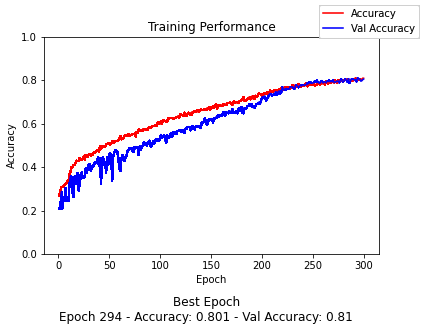

Accuracy: 73.48%
Performing K-Fold 2


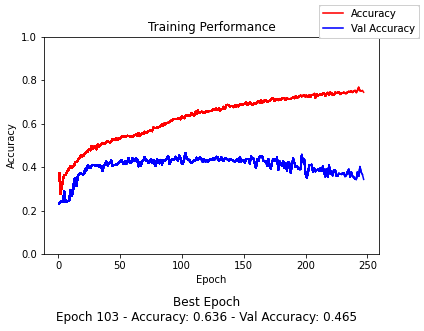

Accuracy: 80.43%
Performing K-Fold 3


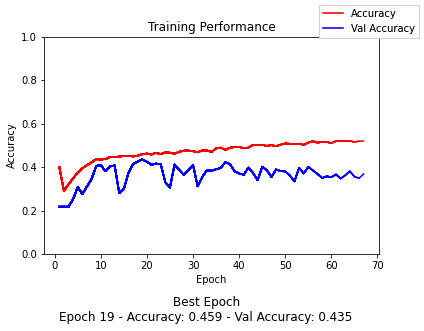

Accuracy: 79.22%
Performing K-Fold 4


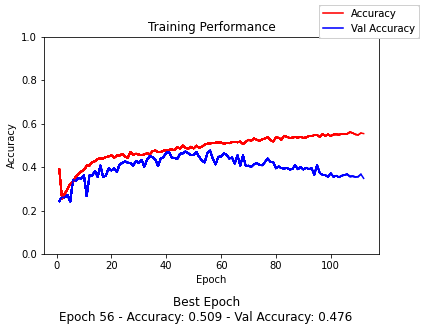

Accuracy: 84.61%
Performing K-Fold 5


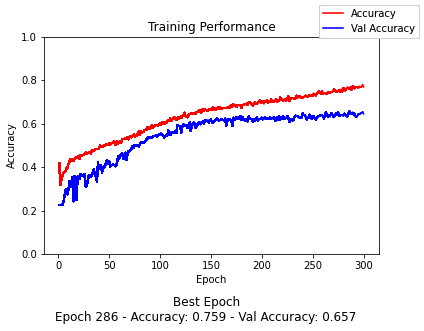

Accuracy: 82.17%
Completed K-Fold Analysis
Acc: 79.98%
Std: 3.72%
Loss: 0.58
Std: 6.00%


In [ ]:
if (KFOLD):
  if (TRAIN_PROCESSING_STAGE != "FULL"):
    raise Exception("Invalid processing stage for KFold Analysis, set TRAIN_PROCESS_STAGE to 'FULL'.")
  kfold = DataGenerator(TRAIN_DIR, SINGLE_SUBJECT_NUM)

  acc_per_fold = []
  loss_per_fold = []

  acc_arr = []
  val_acc_arr = []
  loss_arr = []
  val_loss_arr = []
  Y_test_arr = []
  Yhat_test_arr = []

  fold_no = 1

  for (train, test, val) in kfold.split():
    print("Performing K-Fold {}".format(fold_no))

    if (DIMENSION == '3D'):
      model = build_3d_model()
    elif (DIMENSION == '2D'):
      model = build_2d_model()

    if (BATCH_SIZE != 0):
      history = model.fit(train['X'], train['Y'], validation_data=(val['X'], val['Y']), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE, callbacks=CALLBACKS)
    else:
      history = model.fit(train['X'], train['Y'], validation_data=(val['X'], val['Y']), epochs=EPOCHS, verbose=VERBOSE, callbacks=CALLBACKS)

    if (MODEL_CHECKPOINTING):
      model.load_weights(CHECKPOINT_OUT_DIR)

    metrics_out = model.evaluate(test['X'], test['Y'], verbose=VERBOSE, callbacks=CALLBACKS)

    loss = metrics_out[model.metrics_names.index('loss')]
    acc = metrics_out[model.metrics_names.index('Accuracy')]

    Yhat_test = model.predict(test['X'])

    Yhat_test_cf=np.argmax(Yhat_test, axis=1)
    Y_test_cf=np.argmax(test['Y'], axis=1) 

    Y_test_arr.append(Y_test_cf)
    Yhat_test_arr.append(Yhat_test_cf)

    print("Accuracy: {:.2%}".format(acc))

    acc_arr.append(history.history['Accuracy'])
    val_acc_arr.append(history.history['val_Accuracy'])
    loss_arr.append(history.history['loss'])
    val_loss_arr.append(history.history['val_loss'])

    acc_per_fold.append(acc)
    loss_per_fold.append(loss)
    fold_no += 1

  save_data(acc_arr, val_acc_arr, loss_arr, val_loss_arr, acc_per_fold, loss_per_fold, Y_test_arr, Yhat_test_arr)

  print("Completed K-Fold Analysis")
  print("Acc: {:.2%}".format(np.mean(acc_per_fold)))
  print("Std: {:.2%}".format(np.std(acc_per_fold)))
  
  print("Loss: {:.2}".format(np.mean(loss_per_fold)))
  print("Std: {:.2%}".format(np.std(loss_per_fold)))

else: 
  if (DIMENSION == '3D'):
    model = build_3d_model()
  elif (DIMENSION == '2D'):
    model = build_2d_model()

  history = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, Y_val), verbose=VERBOSE, callbacks=CALLBACKS).history

  if (not LIVE_PLOTTING):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
    plt.show()

  if (MODEL_CHECKPOINTING):
    model.load_weights(CHECKPOINT_OUT_DIR)

  metrics = model.evaluate(X_test, Y_test, verbose=VERBOSE, callbacks=CALLBACKS)
  
  print("Completed Model Training")
  print("Acc: {:.2%}".format(metrics[model.metrics_names.index('Accuracy')]))
  print("Loss: {:.2}".format(metrics[model.metrics_names.index('loss')]))

  Yhat_test = model.predict(X_test)

  Yhat_test_cf=np.argmax(Yhat_test, axis=1)
  Y_test_cf=np.argmax(Y_test, axis=1) 

  # Plotting confusion matrix
  cm = confusion_matrix(Y_test_cf,Yhat_test_cf,normalize='true')
  # Not sure if display_labels is correct
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=DISPLAY_LABELS[:NUM_CLASSES])
  disp.plot()

